In [2]:
import hdf5storage
import numpy as np

data = hdf5storage.loadmat('indy_20160930_02.mat')

In [3]:
from utils import not_moving_filter, get_bins, get_angles, aggregate_angle_bins, collect_spikes, aggregate_spike_bins

In [4]:
time_bin = 0.1
angle_bin = 40
spike_num_threshold = 300
good_score = 0.3

mask = not_moving_filter(data['cursor_pos'])
time_bin_indexs = get_bins(data['t'], time_bin, mask)
angle_vecs = get_angles(data['cursor_pos'], time_bin_indexs)
aggregate_angle_vecs, bin_indices = aggregate_angle_bins(angle_vecs, angle_bin)

## example curve on a single neuron

In [5]:
spikes = data['spikes'][15][1].flatten()
spike_nums = collect_spikes(spikes, time_bin_indexs, data['t'])
aggregate_spike_counts = aggregate_spike_bins(spike_nums, bin_indices, angle_bin)
print(spike_nums.sum())
firing_rate = aggregate_spike_counts / time_bin

425.0


0.4487591056608333


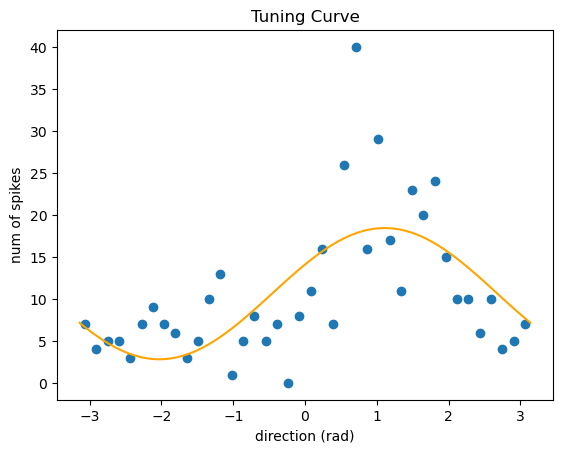

In [6]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
model = LinearRegression()
plt.scatter(np.arctan2(aggregate_angle_vecs[:, 1], aggregate_angle_vecs[:, 0]), aggregate_spike_counts)
plt.xlabel('direction (rad)')
plt.ylabel('num of spikes')
plt.title('Tuning Curve')
res = model.fit(aggregate_angle_vecs, firing_rate)
print(res.score(aggregate_angle_vecs, firing_rate))
xaxis = np.linspace(-np.pi, np.pi, 100)
xvecs = np.stack((np.cos(xaxis), np.sin(xaxis)), axis=1)
y_pred = model.predict(xvecs)
plt.plot(xaxis, y_pred * time_bin, color='orange')
plt.savefig('bad_fitting.png')

## $R^2$ distribution

In [7]:
from sklearn.linear_model import LinearRegression
r2_scores = []
good_neurons = []
for channel_id, channel in enumerate(data['spikes']):
    for i, neuron in enumerate(channel):
        if i == 0:
            continue
        spikes = neuron.flatten()
        if len(spikes) < spike_num_threshold:
            continue
        spike_nums = collect_spikes(spikes, time_bin_indexs, data['t'])
        aggregate_spike_counts = aggregate_spike_bins(spike_nums, bin_indices, angle_bin)
        firing_rate = aggregate_spike_counts / time_bin
        model = LinearRegression()
        res = model.fit(aggregate_angle_vecs, firing_rate)
        r2_score = res.score(aggregate_angle_vecs, firing_rate)
        if r2_score > good_score:
            good_neurons.append([channel_id, i])
        r2_scores.append(res.score(aggregate_angle_vecs, firing_rate))

In [8]:
good_neurons = np.stack(good_neurons, axis=0)
np.save('good_neurons.npy', good_neurons)

130


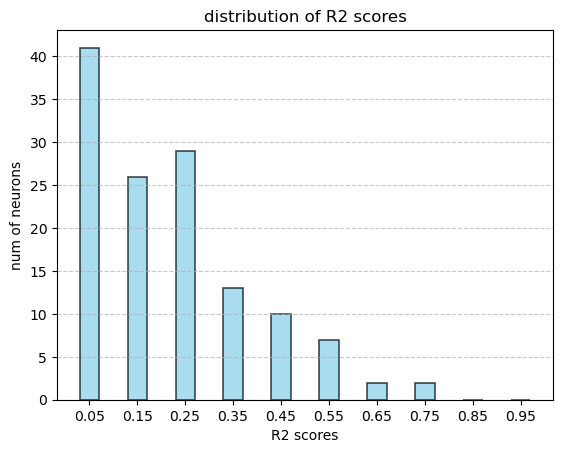

In [9]:
print(len(r2_scores))
bin_edges = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges) - 1)]
plt.hist(r2_scores, bins=bin_edges, rwidth=0.4, edgecolor='black', linewidth=1.2, alpha=0.7, color='skyblue')
plt.xticks(bin_centers)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('num of neurons')
plt.xlabel('R2 scores')
plt.title('distribution of R2 scores')
plt.show()

## motion and firing rate visualization of single neuron
`conda update ffmpeg` is needed, if conda environment is used

/tmp/ipykernel_648559/4014278628.py:56: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(x, y)
/tmp/ipykernel_648559/4014278628.py:57: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point2.set_data(x2, y2)


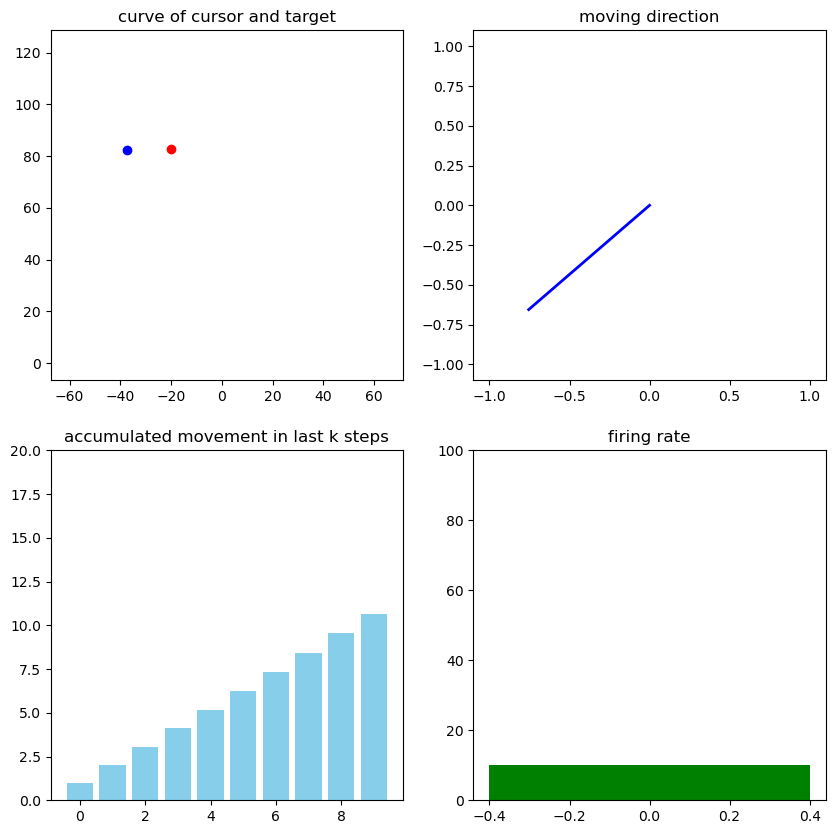

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 1300 - 1400 is a smooth curve

start, end = 1000, 3000

sliced = slice(start, end)
coordinates = data['cursor_pos'][sliced]
target_pos = data['target_pos'][sliced]
diff = np.diff(data['cursor_pos'], axis=0)
norm = np.linalg.norm(diff, axis=1, keepdims=True)
normalized_diff = diff / norm       
normalized_diff = normalized_diff[sliced]
slice_mask = mask[sliced]
sliced_t = data['t'][sliced]
spikes = data['spikes'][15][1].flatten()

# 创建一个新的图形
fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
ax.set_xlim(data['cursor_pos'][:, 0].min(), data['cursor_pos'][:, 0].max())
ax.set_ylim(data['cursor_pos'][:, 1].min(), data['cursor_pos'][:, 1].max())
ax.set_title('curve of cursor and target')
ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax2.set_title('moving direction')
ax3.set_ylim(0, 20)
ax3.set_title('accumulated movement in last k steps')
ax4.set_ylim(0, 100)
ax4.set_title('firing rate')


# 初始化一个点
point, = ax.plot([], [], 'ro')  # 'ro' 表示红色的圆圈
point2, = ax.plot([], [], 'bo')
vector, = ax2.plot([], [], 'g-', lw=2)
bars = ax3.bar(range(10), [0]*10, color='skyblue')
spikebars = ax4.bar(range(1), [0]*1, color='green')

def init():
    # 初始化函数，设置动画的起始状态
    point.set_data([], [])
    point2.set_data([], [])
    vector.set_data([], [])
    for bar in bars:
        bar.set_height(0)
    for spikebar in spikebars:
        spikebar.set_height(0)
    return point, point2, vector, *bars, *spikebars

def update(frame):
    # 更新函数，用于更新每一帧的数据
    x, y = coordinates[frame]
    x2, y2 = target_pos[frame]
    x3, y3 = normalized_diff[frame]
    point.set_data(x, y)
    point2.set_data(x2, y2)
    if slice_mask[frame] == 0:
        vector.set_color('red')
    else:
        vector.set_color('blue')
    vector.set_data([0, x3], [0, y3])
    for i, bar in enumerate(bars):
        if frame - i - 1 >= 0:
            bar.set_height(np.linalg.norm(coordinates[frame] - coordinates[frame-i-1]))
        else:
            bar.set_height(0)
    for i, bar in enumerate(spikebars):
        count = 0
        for spike_time in spikes:
            if sliced_t[frame] - 0.1 < spike_time and spike_time < sliced_t[frame]:
                count += 1
            if spike_time >= sliced_t[frame]:
                break
        bar.set_height(count / 0.1)

    return point, point2, vector, *bars, *spikebars

# 创建动画
ani = animation.FuncAnimation(fig, update, frames=coordinates.shape[0], init_func=init, blit=True)

ani.save("movie_slow.mp4", fps=50, writer="ffmpeg")
# 显示动画
plt.show()